# `VTKtools` Documentation

In [1]:
module_path,_ = splitdir(@__FILE__);   # Path to this module
push!(LOAD_PATH, joinpath(module_path,"../src/")) # Point to VTKtools source

# Load VTKtools
using VTKtools                         
vtk = VTKtools

# Load examples
include(joinpath(module_path,"../examples/examples.jl"))    
pygui(false);

## Geometric Manipulation

### Discretization

In [2]:
?vtk.discretize

`discretize(f, xlow, xhigh, n::Int64, r::Float64; central::Bool=false)`

Discretizes the continuous function `f` between the range `xlow` and `xhigh` into `n` intervals, with `r` the ratio between first and last interval if `central=false` or between first and central interval if `central=true`.

**Examples**

The following lines show the discretization of a semi-circumference perimeter   into 100 intervals of uniform length:

`julia     julia> f(x) = (x, sqrt(1-round(x,8)^2), 0)  # Semi-circunference of radius 1     julia> discretize(f, -1, 1, 100, 1.0)`


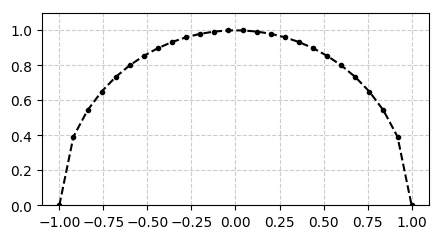

In [3]:
f(x) = (x, sqrt(1-round(x,8)^2), 0)

points = vtk.discretize(f, -1, 1, 25, 1.0)

function plot1(points)
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    z = [p[3] for p in points]

    fig = figure("", figsize=(5,2.5))
    plot(x,y, "--.k")
    xlim([-1, 1]*1.1)
    ylim([0, 1]*1.1)
    grid(true, color="0.8", linestyle="--")
end

plot1(points)

However, parameterizing the curve as `f(x) = (x, sqrt(1-x^2), 0)`, the discretization was done evenly spaced in `x`. If we want to evenly space the path of the curve, we'd be better off parameterizing it as `f(theta) = (cos(theta), sin(theta), 0)`:

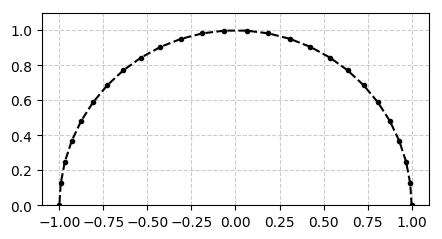

In [4]:
f(theta) = (cos(theta), sin(theta), 0)
points = vtk.discretize(f, 0, pi, 25, 1.0)
plot1(points)

That looks better. If now we want to increase the step size as we go along the curve (`r=1/8`):

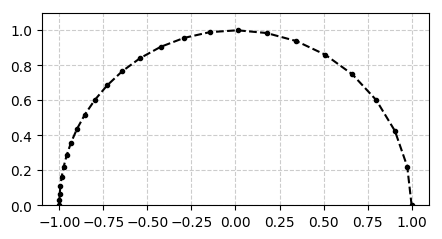

In [5]:
points = vtk.discretize(f, 0, pi, 25, 1/8)
plot1(points)

If we want to center that spacing we give `central=true`:

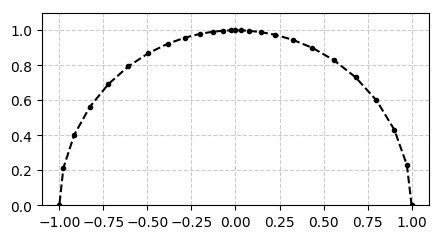

In [6]:
points = vtk.discretize(f, 0, pi, 25, 1/8; central=true)
plot1(points)

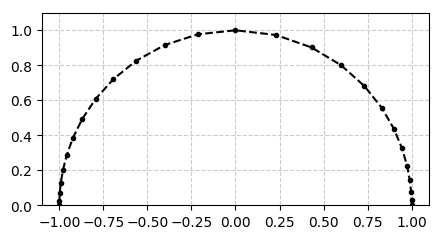

In [7]:
points = vtk.discretize(f, 0, pi, 25, 8.0; central=true)
plot1(points)

In order to define multiple sections of refinement, the function `multidiscretize` can be used:

In [8]:
?vtk.multidiscretize

`multidiscretize(f, xlow, xhigh, sections)`

Discretizes the continuous function `f` between the range `xlow` and `xhigh` into multiple sections of refinement as specified in `sections`.

** Arguments **

  * `f`         : Continuous function of the form `f(x)` to be discretized               between `xlow` and `xhigh`,
  * `xlow`      : Lower bound.
  * `xhigh`     : Upper bound.
  * `sections`  : Array `[sec1, sec2, ...]`specifying the               sections of discretization in the format               `sec = (c::Float64, n::Int64, r::Float64, central::Bool)`,               with `c` the normalized length of this section (the sum of all               c must equal one), `n` the number of intervals in this section               , `r` the increment ratio between first and last interval if               `central=false` or between first and central interval if               `central=true`.

**Examples**

The following lines show the discretization of a semi-circumference perimeter   into 90 intervals done in three sections of discretization:

`julia     julia> f(theta) = (cos(theta), sin(theta), 0)     julia> sec = (1/3, 30, 1/8, true)     julia> points = multidiscretize(f, 0, pi, [sec, sec, sec])`


Here we will discretize the semi-circle in three different sections of refinement:

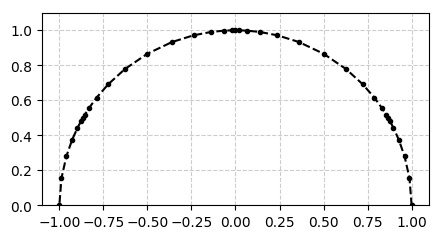

In [9]:
sec = (1/3, 12, 1/8, true)
points = vtk.multidiscretize(f, 0, pi, [sec, sec, sec])

plot1(points)

Let's verify that the are returned in the right order:

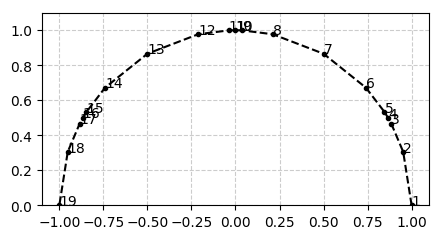

In [10]:
sec = (1/3, 6, 1/8, true)
points = vtk.multidiscretize(f, 0, pi, [sec, sec, sec])

plot1(points)

# Numbering
for (i,(x,y,z)) in enumerate(points)
    annotate("$i", xy=(x,y), xytext=(x,y))
end

### Meshing

In order to exemplify how to mesh on a surface, we will show the example of a helicoidal surface. First, outer and inner edges are defined analytically:

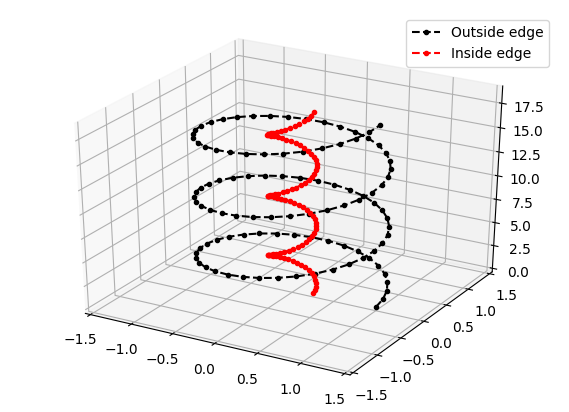

PyObject <matplotlib.legend.Legend object at 0x7f20e9233cd0>

In [11]:
# Helicoid function
rho,k = 1,1
f(z) = [rho*cos(k*z), rho*sin(k*z), z]

# Discretize
points1 = vtk.discretize(f, 0, 3*2*pi, 100, 1.0)
rho = rho/4
points2 = vtk.discretize(f, 0, 3*2*pi, 100, 1.0)

function plot2(points; label="", style="--.k")
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    z = [p[3] for p in points]

    fig = figure("", figsize=(7,5))
    ax = gca(projection="3d")
    plot(x,y,z, style, label=label)
    xlim([-1, 1]*1.5)
    ylim([-1, 1]*1.5)
    if label!=""
        legend(loc="best")
    end
end

plot2(points1; label="Outside edge")
plot2(points2; label="Inside edge", style="--.r")

In [12]:
?vtk.lines2vtkcells

`lines2vtkcells(line1::Array{Array{Float64,1}},line2::Array{Array{Float64,1}};                     point_data1, point_data2)`

Given two lines with the same amount of points, it generate cells in VTK format by matching the points between lines. For instance:

`julia   julia> line1 = [p11,p12,p13]   julia> line2 = [p21,p22,p23]   julia> lines2vtkcells(line1, line2)   (points, vtk_cells, point_data)` where `points=[p11,p12,p13,p21,p22,p23]`, and `vtk_cells=[[0,1,4,3],[1,2,5,4]]`.

Give it point data corresponding to points in each line through `point_data1` and `point_data2`, and it return it through `point_data` formatted for `generateVTK`'s `point_data` input.

Prefer this method over `generateCells()` since it will store the data efficiently when generating the VTK.


The entire case can is found in `parametric_mesh()` under `examples.jl`, resulting in the following geometry:

<img src="img/helicoid00.png" alt="Pic here" style="width: 600px;"/>

Run the following cell to generate and visualize the mesh in Paraview:

In [32]:
parametric_mesh(; prompt=false)

And `parametric_mesh2()` adds divisions in between outer and inner edges:

<img src="img/helicoid01.png" alt="Pic here" style="width: 600px;"/>

Run the following cell to generate and visualize the mesh in Paraview:

In [14]:
?vtk.lines2vtkmulticells

`lines2vtkmulticells(line1, line2,                           sections::Array{Tuple{Float64,Int64,Float64,Bool},1},                           point_data1=nothing, point_data2=nothing)`

Like `lines2vtkcells()` it generates cells between two lines, but allows to define multiple rows of cells in between. The rows are given by `sections`, which is the same variable `sections` defined in `VTKtools_geometry.jl`'s `multidiscretize()` function, which divides the space in between the lines. For more details see docstring of `lines2vtkcells()` and `multidiscretize()`.


In [15]:
parametric_mesh2(; prompt=false)

### Parametrization

#### 2D Case - Semicircle

Given a set of 2D points $X = \{(x,y)\}$ that define a discretized 2D contour, the contour will be parametrized using the path of the contour. First, the contour is splined defining the function $f$ such that $X$ becomes $X = \{(x, f(x))\}$. The path $\Delta s$ between $(x,\mathop{}f(x))$ and $(x+\Delta x, \mathop{}f(x+\Delta x))$  is 

\begin{align}
        \Delta s(x, \Delta x) & = \sqrt{ (\Delta x)^2 + (f(x+\Delta x) - f(x))^2 }
    \\
        & = \sqrt{ 1 + \Big(\frac{f(x+\Delta x) - f(x)}{\Delta x}\Big)^2 } (\Delta x)
.\end{align}

In the limit $\Delta x\rightarrow 0$, 

\begin{align}
        \text{d} s (x) & = 
            \sqrt{ 1 + \Big(\frac{\text{d} f}{\text{d} x}(x)\Big)^2 } \text{d} x
;\end{align}

hence, the path $s$ from $(x_\text{min}, f(x_\text{min}))$ to an arbitrary point $(x, f(x))$ is calculated as

\begin{align}
    s(x) = \int\limits_{x_\text{min}}^{x} 
            \sqrt{ 1 + \Big(\frac{\text{d} f}{\text{d} x}(x^\prime)\Big)^2 } 
                            \text{d} x^\prime
\end{align}

For instance, lets show the path of the semi-circle used above, where the analytical circunference is originally discretized in $x$ instead of $\theta$, making non-evenly spaced discretization. The code below shows the spline (function $f(x)$) through the points resulting from the discretization, and the path function $s(x)$ is defined:

Path length between xmin=-1 and x=1: 3.136808464134872


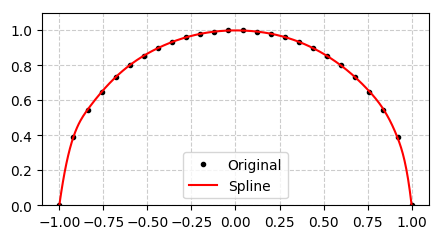

Expected value: π = 3.1415926535897...


In [16]:
using QuadGK

# Semi-circunference parameterized about x
f(x) = (x, sqrt(1-round(x,8)^2), 0)

# Discretize into points non-evenly spaced
points = vtk.discretize(f, -1, 1, 25, 1.0)

# Plot
function plot3(points; label="", style="--.k")
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    z = [p[3] for p in points]

    fig = figure("", figsize=(5,2.5))
    plot(x,y, style, label=label)
    xlim([-1, 1]*1.1)
    ylim([0, 1]*1.1)
    grid(true, color="0.8", linestyle="--")
    if label!=""; legend(loc="best"); end;
end

plot3(points; label="Original", style=".k")

# Fitting a spline through the points
x = [point[1] for point in points]
y = [point[2] for point in points]
bc="extrapolate"                 # Out of boundary case
s=0.0001                   # Spline smoothness
k = min(size(x)[1]-1, 3)   # Spline order
spl = vtk.Dierckx.Spline1D(x, y; k=k, bc=bc, s=s)

# Plots the spline
points2 = [(xi, spl(xi), 0) for xi in -1:0.005:1]
plot3(points2; label="Spline", style="-r")

# Defines the path function
dfdx(x) = vtk.Dierckx.derivative(spl, x)        # Derivative of f
fun(x) = sqrt.(1+(dfdx(x)).^2)                  # Integrand
fun_s(this_x) = quadgk(fun, x[1], this_x)[1]    # Integral between xmin and x

# Verification: path at x=1 should be 3.1415926535897...
println("Path length between xmin=-1 and x=1: $(fun_s(1.0))")
println("Expected value: $pi")

Now we will use the path function $s$ as a parametrization for re-discretizing the curve into evenly-spaced intervals. First, we normalize the path function as 

\begin{align}
    s^*(x) = \frac{s(x)}{s_\text{tot}}
,\end{align}

with $s_\text{tot} = s(x_\text{max})$. Next we define the inverse function $s^{-1}(s) = x$, or the normalized inverse function $s^{-1*}(s^*) = s^{-1}(s_\text{tot} s^*) = x$. Hence, $s^{-1*}$ receives any number between 0 and 1 representing the position along the path, and returns the value of $x$ that corresponds to that position. Implementing this numerically requires using a root finder as follows:

In [17]:
using Roots

stot = fun_s(x[end])      # Total length of the path
norm_s(x) = fun_s(x)/stot # Normalized path function

function inv_norm_s(sstar; debug=false)
    # ERROR CASES
    if sstar<-0.001 || sstar>1.001 # Outside of domain
        error("Invalid normalized path length $(sstar) (sstar<0 || sstar>1)")
    end
    
    # Finds the x that matches the target (sstar)
    this_fun(x) = sstar - norm_s(x)
    bracket = [ x[1]*(1-0.01*sign(x[1])) , x[end]*(1+0.01*sign(x[end]))]
    if debug
        println("sstar=$sstar\tbracket=$bracket")
        println("flow=$(this_fun(bracket[1]))")
        println("fup=$(this_fun(bracket[2]))")
    end
    this_x = Roots.find_zero(this_fun, bracket, Roots.Bisection())
    
    return this_x
end

# Verification: x for s*=0.5 must equal 0
println("x for s*=0.5 (half way the path): $(inv_norm_s(0.5))")
println("Expected value: 0.0")

x for s*=0.5 (half way the path): -0.00048069199737853794
Expected value: 0.0


Now we can use this new parameterization to re-discretize the curve into evenly-spaced intervals. First we redefine the original function $f$ as $f^*: [0,1]\rightarrow \mathbb{R}^3 \mathop{/} f^*(s^*) = f(s^{-1*}(s^*))$, and then we discretize $s^*$ as we may in [0,1]:

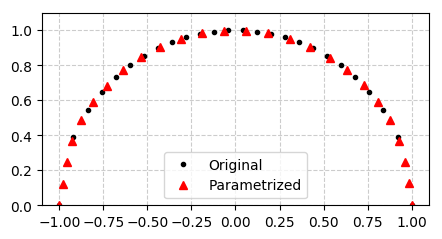

PyObject <matplotlib.legend.Legend object at 0x7f20e8f15f90>

In [18]:
# Redefine the original function in terms of the new parametrization s*
function fstar(sstar)
    x = inv_norm_s(sstar)
    return (x, spl(x), 0)
end

# Discretize into points evenly spaced
points3 = vtk.discretize(fstar, 0, 1, 25, 1.0)
plot3(points; label="Original", style=".k")
plot3(points3; label="Parametrized", style="^r")

And we get an evenly-spaced discretization. Also, we can use this new parametrization to re-discretizase the original curve as we please:

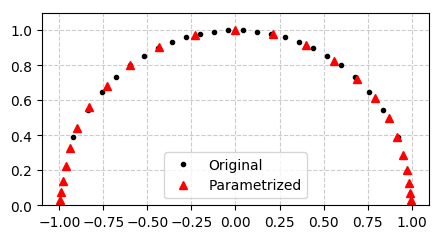

PyObject <matplotlib.legend.Legend object at 0x7f20e8e09c10>

In [19]:

# Finer discretization at the ends
points4 = vtk.discretize(fstar, 0, 1, 25, 8.0; central=true)
plot3(points; label="Original", style=".k")
plot3(points4; label="Parametrized", style="^r")

#### 3D Case - Helicoid

This paramaetrization method for obtaining $f^*$ is implemented in `parameterize()`, which receives a 3D contour line and returns the function $f^*$:

In [20]:
?vtk.parameterize

`parameterize(x, y, z; inj_var::Int64=1, s=0.0001, debug=false)`

Receives a contour (line) and returns a parametrization function f(s) of the contour. The parametrization is done on the path of the splined contour such that f(0.5) returns the point (x,y,z) where half of the entire contour has been walked, and f(1.0) returns the last point in the contour. To perform this parametrization, the contour must be injective in least one of the variables (x, y, or z) (i.e., all values of the variable are unique), and that variable must be given in increasing order.

**Arguments**

  * `x::Array{Float64,1}`    : x-coordinates of the contour.
  * `y::Array{Float64,1}`    : y-coordinates of the contour.
  * `z::Array{Float64,1}`    : z-coordinates of the contour.

**Optional Arguments**

  * `inj_var::Int64`         : Indicates the variable that is injective, with                               1=x, 2=y, and 3=z.
  * `s::Float64`             : Spline smoothness.

See Parametrization section in documentation for more details.


As an example, lets take a collection of points representing a helicoid as follows:

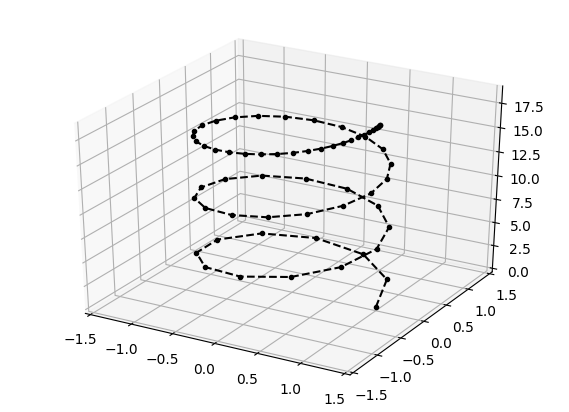

In [21]:
# Helicoid function
rho,k = 1,1
f(z) = [rho*cos(k*z), rho*sin(k*z), z]

# Discretize
points1 = vtk.discretize(f, 0, 3*2*pi, 60, 1/100.0)

function plot2(points; label="", style="--.k")
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    z = [p[3] for p in points]

    fig = figure("", figsize=(7,5))
    ax = gca(projection="3d")
    plot(x,y,z, style, label=label)
    xlim([-1, 1]*1.5)
    ylim([-1, 1]*1.5)
    if label!=""
        legend(loc="best")
    end
end

plot2(points1)

This curve has been discretize with a large concetration of points in the upper part, and very sparse in the bottom. We can use `parameterize` to obtain the curve again and be able to re-discretize is as we please:

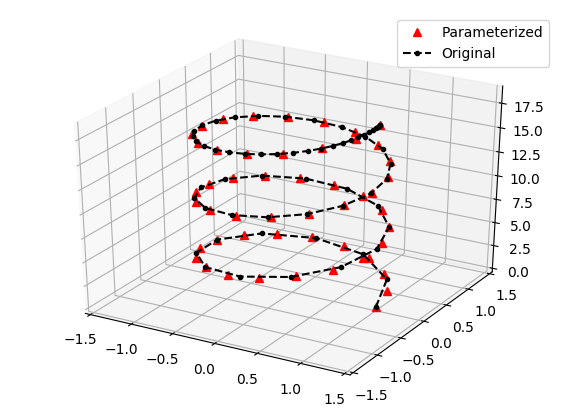

PyObject <matplotlib.legend.Legend object at 0x7f20e8d08fd0>

In [22]:
# Splits the points into x,y,z
x = [p[1] for p in points1]
y = [p[2] for p in points1]
z = [p[3] for p in points1]

# Parametrization function f*
this_fstar = vtk.parameterize(x,y,z; inj_var=3)
# Note: In this case the injective variable is z, hence inj_var=3

# Discretize f* evenly-spaced
points2 = vtk.discretize(this_fstar, 0, 1, 50, 1.0)

plot2(points2; style="^r", label="Parameterized")
plot2(points1; style="--.k", label="Original")

#### Arbitrary geometry - Airfoil

Why is this useful?? Let's show an application of this on an airfoil.

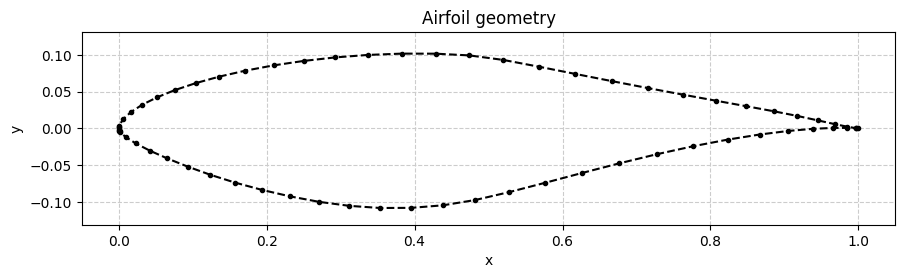

In [23]:
x,y = readcontour("../data/S809.txt"; header_len=2)
plot_airfoil(x,y; style="--.k")

We can use those parametrization and discretization methods for redoing the sectioning of the airfoil in a more refined, evenly-spaced discretization:

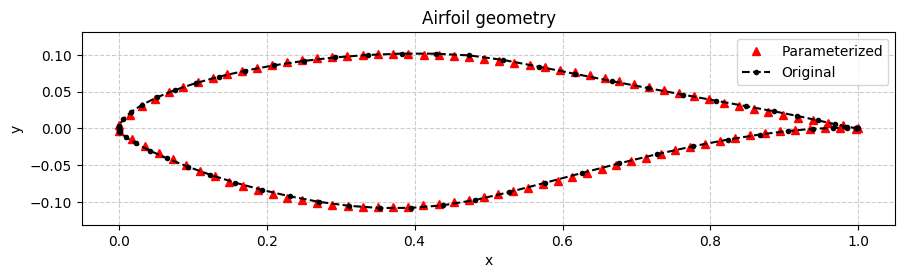

PyObject <matplotlib.legend.Legend object at 0x7f20e933de10>

In [24]:
# Separate upper and lower surfaces to make the contour injective in x
upper, lower = splitcontour(x,y)

# Parameterize both surfaces independently
fun_upper = vtk.parameterize(upper[1], upper[2], zeros(upper[1]); inj_var=1)
fun_lower = vtk.parameterize(lower[1], lower[2], zeros(lower[1]); inj_var=1)

# New discretization for both surfaces
upper_points = vtk.discretize(fun_upper, 0, 1, 50, 1.0)
lower_points = vtk.discretize(fun_lower, 0, 1, 50, 1.0)

# Put both surfaces back together from TE over the top and from LE over the bottom.
reverse!(upper_points)                           # Trailing edge over the top
new_x = [point[1] for point in upper_points]
new_y = [point[2] for point in upper_points]     # Leading edge over the bottom
new_x = vcat(new_x, [point[1] for point in lower_points])
new_y = vcat(new_y, [point[2] for point in lower_points])

plot_airfoil(new_x, new_y; style="^r", label="Parameterized")
plot_airfoil(x,y; style="--.k", label="Original")
legend(loc="best")

Or maybe we want to refine leading and trailing edges, along the apex:

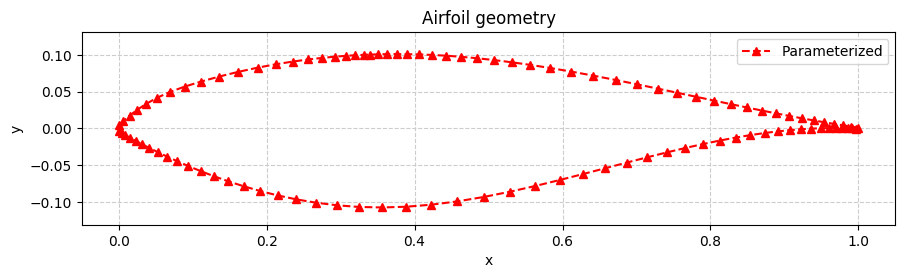

PyObject <matplotlib.legend.Legend object at 0x7f20e9264190>

In [25]:
# Upper surface sections
sec1 = (0.35, 20, 3.0, true) # 35% of the line has 20 sections in ratio 3.0 around center
sec2 = (0.65, 33, 3.0, true) # 65% of the line has 33 sections in ratio 3.0 around center

# New discretization for both surfaces
upper_points = vtk.multidiscretize(fun_upper, 0, 1, [sec1,sec2])
lower_points = vtk.discretize(fun_lower, 0, 1, 50, 8.0; central=true)

# Put both surfaces back together from TE over the top and from LE over the bottom.
reverse!(upper_points)                           # Trailing edge over the top
new_x = [point[1] for point in upper_points]
new_y = [point[2] for point in upper_points]     # Leading edge over the bottom
new_x = vcat(new_x, [point[1] for point in lower_points])
new_y = vcat(new_y, [point[2] for point in lower_points])

plot_airfoil(new_x, new_y; style="--^r", label="Parameterized")

### Example: Wing

Now we will show how we can use parametrization + discretization + meshing to create a geometry. This example is on an airplane wing, but the same procedure can be follow for defining any surface of lofted cross sections.

First, we take two airfoils as downloaded from airfoilstools.com, use `parametrize()` to parameterize their contours and `discretize()` to discretize with a finer sections towards both trailing and leading edge, and apex:

In [26]:

# PARAMETERS
n_up = 40             # Number of sections in upper surface of wing
n_lower = 20          # Number of sections in lower surface of wing
z1 = 0.0              # Position of first airfoil
z2 = 10.0             # Position of second airfoil
c1 = 2.5              # Chord of first airfoil
c2 = 1.0              # Chord of second airfoil
file_name = "temp_wing00"    # Name for vtk outpout file

# Reads the original airfoil geometry from airfoiltools.com
org_x1, org_y1 = readcontour("../data/naca6412.dat"; header_len=1)
org_x2, org_y2 = readcontour("../data/naca0006.dat"; header_len=1)

# Separate upper and lower sides to make the contour injective in x
upper1, lower1 = splitcontour(org_x1, org_y1)
upper2, lower2 = splitcontour(org_x2, org_y2)

# Parameterize both sides independently
fun_upper1 = vtk.parameterize(upper1[1], upper1[2], zeros(upper1[1]); inj_var=1)
fun_lower1 = vtk.parameterize(lower1[1], lower1[2], zeros(lower1[1]); inj_var=1)
fun_upper2 = vtk.parameterize(upper2[1], upper2[2], zeros(upper2[1]); inj_var=1)
fun_lower2 = vtk.parameterize(lower2[1], lower2[2], zeros(lower2[1]); inj_var=1)

# Upper surface sections
aux1 = Int(floor(20/53*n_up))
sec1 = (0.35, aux1, 3.0, true) # 35% of the line has 20 sections in ratio 3.0 around center
sec2 = (0.65, n_up-aux1, 3.0, true) # 65% of the line has 33 sections in ratio 3.0 around center

# New discretization for both surfaces
upper_points1 = vtk.multidiscretize(fun_upper1, 0, 1, [sec1,sec2])
lower_points1 = vtk.discretize(fun_lower1, 0, 1, n_lower, 8.0; central=true)
upper_points2 = vtk.multidiscretize(fun_upper2, 0, 1, [sec1,sec2])
lower_points2 = vtk.discretize(fun_lower2, 0, 1, n_lower, 8.0; central=true)

# Put both surfaces back together from TE over the top and from LE over the bottom.
reverse!(upper_points1)                           # Trailing edge over the top
new_x1 = [point[1] for point in upper_points1]
new_y1 = [point[2] for point in upper_points1]     # Leading edge over the bottom
new_x1 = vcat(new_x1, [point[1] for point in lower_points1])
new_y1 = vcat(new_y1, [point[2] for point in lower_points1])
reverse!(upper_points2)                           # Trailing edge over the top
new_x2 = [point[1] for point in upper_points2]
new_y2 = [point[2] for point in upper_points2]     # Leading edge over the bottom
new_x2 = vcat(new_x2, [point[1] for point in lower_points2])
new_y2 = vcat(new_y2, [point[2] for point in lower_points2])
println("")

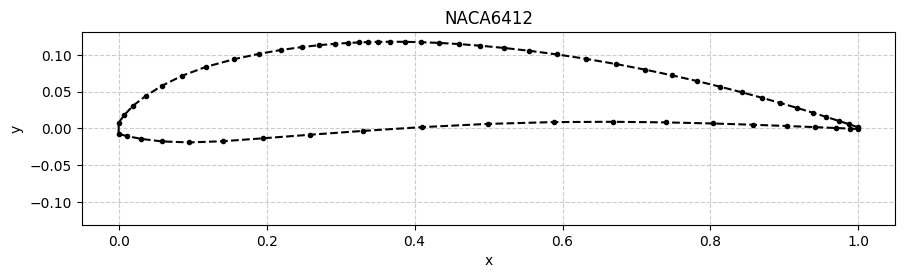

In [27]:
plot_airfoil(new_x1, new_y1; style="--.k", title_str="NACA6412")

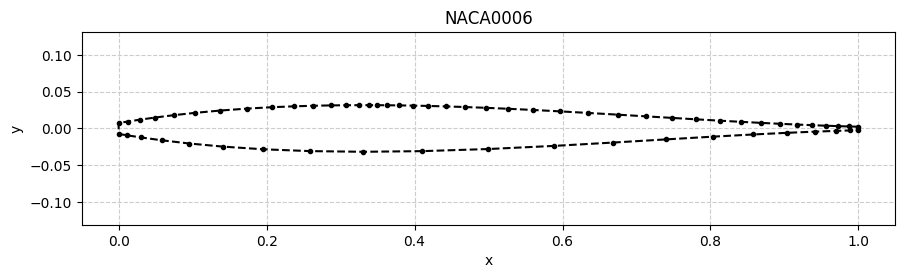

In [28]:
plot_airfoil(new_x2, new_y2; style="--.k", title_str="NACA0006")

Now we can use `lines2vtkmulticells()` to generate a lofted 3D surface between both airfoils and output it in VTK Legacy format using `generateVTK()`:

In [29]:
npoints = size(new_x1)[1]         # Number of points on each airfoil contour
# Dimensions the airfoil acording to their chord length and positions them in z
airfoil1 = [[c1*new_x1[i], c1*new_y1[i], z1] for i in 1:npoints]
airfoil2 = [[c2*new_x2[i], c2*new_y2[i], z2] for i in 1:npoints]

# Discretization of the lofting between the airfoils
nloft = 50                      # Number of sections
rloft = 10.0                   # Expansion ratio
central = true                  # Expands about center between edges
sections = [(1.0, nloft, rloft, central)]   # Discretization sections

# Dummy point data for good looking visuals
pd1 = [i for i in 1:size(airfoil1)[1]]
pd2 = size(airfoil1)[1]+[i for i in 1:size(airfoil2)[1]]

# Generates cells in VTK Legacy format
out = vtk.lines2vtkmulticells(airfoil1, airfoil2, sections;
                                        point_data1=pd1, point_data2=pd2)
points, vtk_cells, point_data = out


# Formats the point data for generateVTK
data = []
push!(data, Dict(
              "field_name" => "Point_index",
              "field_type" => "scalar",
              "field_data" => point_data
              )
   )


# Generates the vtk file
vtk.generateVTK(file_name, points; cells=vtk_cells, point_data=data)

Visualize in Paraview:

In [30]:

# Calls paraview
run(`paraview --data="$(file_name).vtk;"`)


# Deletes files
if false
 print("Delete vtk files? ([y]/n) ")
 y = readline()
else
 y = "y"
end
if y=="y"; run(`rm -f $(file_name).vtk`); end;


<img src="img/wing00.png" alt="Pic here" style="width: 600px;"/>
<img src="img/wing01.png" alt="Pic here" style="width: 600px;"/>
<img src="img/wing02.png" alt="Pic here" style="width: 600px;"/>

### Example: Blade

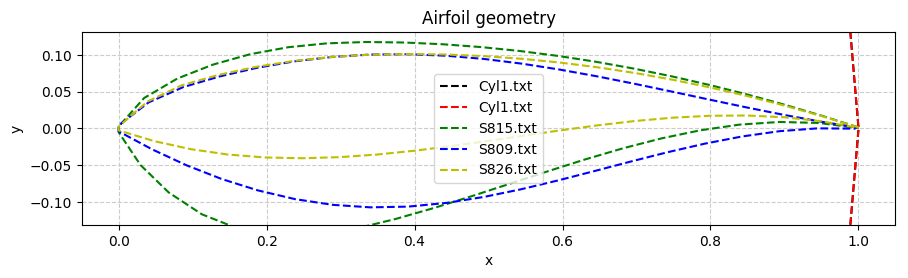

In [31]:
airfoil_files = ["Cyl1.txt", "Cyl1.txt", "S815.txt", "S809.txt", "S826.txt"]
file_name = "temp_blade00"    # Name for vtk outpout file
prompt = false

# PARAMETERS
n_upper = 20             # Number of sections in upper surface of blade
n_lower = 20          # Number of sections in lower surface of blade
r = [1.0, 1.0, 8.0, 8.0, 8.0]           # Expansion ratio in both surfaces of each airfoil
sections = [[(1.0, 10, 1.0, false)],      # Discretization between each airfoil
          [(1.0, 5, 1.0, false)],
          [(1.0, 15, 1.0, false)],
          [(1.0, 10, 1.0, false)],
  ]

Rtip = 25.0           # Radius at blade tip
Rhub = 1.0            # Radius of the hub
pos = [0, 0.15, 0.2, 0.5, 1.0]           # Position along blade of each airfoil
chords = [1.0, 0.6, 1.75, 3.0, 0.85]    # Chord length of each airfoil

# Leading edge position of each airfoil
Os = [[-chords[1]/2, 0, Rhub+pos[1]*(Rtip-Rhub)],
      [-chords[2]*7/8, 0, Rhub+pos[2]*(Rtip-Rhub)],
      [-chords[3]*4/6, 0, Rhub+pos[3]*(Rtip-Rhub)],
      [-chords[4]/4, 0, Rhub+pos[4]*(Rtip-Rhub)],
      [-chords[5]/8, 0, Rhub+pos[5]*(Rtip-Rhub)]
  ]
# Orientation of chord of each airfoil (yaw, pitch, roll)
orien = [ [0.0, 0.0, 0.0],
          [0.0, 0.0, 0.0],
          [10.0, 0.0, 0.0],
          [7.5, 0.0, 0.0],
          [0.0, 30.0, 0.0]
]

crosssections = []        # It will store here the cross sections for lofting
point_datas = []          # Dummy point data for good looking visuals

# Processes each airfoil geometry
styles = ["--k", "--r", "--g", "--b", "--y", "--c"]
org_points = []
for (i,airfoil_file) in enumerate(airfoil_files)

  # Read airfoil file
  x,y = readcontour(vtk.data_path*airfoil_file; header_len=2)
  push!(org_points, [x,y])

  # Separate upper and lower sides to make the contour injective in x
  upper, lower = splitcontour(x, y)

  # Parameterize both sides independently
  fun_upper = vtk.parameterize(upper[1], upper[2], zeros(upper[1]); inj_var=1)
  fun_lower = vtk.parameterize(lower[1], lower[2], zeros(lower[1]); inj_var=1)

  # New discretization for both surfaces
  upper_points = vtk.discretize(fun_upper, 0, 1, n_upper, r[1]; central=true)
  lower_points = vtk.discretize(fun_lower, 0, 1, n_lower, r[1]; central=true)

  # Put both surfaces back together from TE over the top and from LE over the bottom.
  reverse!(upper_points)                           # Trailing edge over the top
  new_x = [point[1] for point in upper_points]
  new_y = [point[2] for point in upper_points]      # Leading edge over the bottom
  new_x = vcat(new_x, [point[1] for point in lower_points])
  new_y = vcat(new_y, [point[2] for point in lower_points])

  plot_airfoil(new_x, new_y; style=styles[i], label=airfoil_file)
#     println("Close figure and press ENTER")
#     readline()

  # Scales the airfoil acording to its chord length
  new_x = chords[i]*new_x
  new_y = chords[i]*new_y

  # Reformats into points
  npoints = size(new_x)[1]
  airfoil = Array{Float64, 1}[[new_x[j], new_y[j], 0] for j in 1:npoints]

  # Positions the airfoil along the blade in the right orientation
  Oaxis = vtk.rotation_matrix(orien[i][1], orien[i][2], orien[i][3])
  invOaxis = inv(Oaxis)
  airfoil = vtk.countertransform(airfoil, invOaxis, Os[i])

  push!(crosssections, airfoil)
  push!(point_datas, [j for j in npoints*(i-1)+1:npoints*i])
end

# Generates cells in VTK Legacy format
out = vtk.multilines2vtkmulticells(crosssections, sections;
                                    point_datas=point_datas)
points, vtk_cells, point_data = out


# Formats the point data for generateVTK
data = []
push!(data, Dict(
          "field_name" => "Point_index",
          "field_type" => "scalar",
          "field_data" => point_data
          )
)


# Generates the vtk file
vtk.generateVTK(file_name, points; cells=vtk_cells, point_data=data)

# Calls paraview
run(`paraview --data="$(file_name).vtk;"`)


# Deletes files
if prompt
print("Delete vtk files? ([y]/n) ")
y = readline()
else
y = "y"
end
if y=="y"; run(`rm -f $(file_name).vtk`); end;


<img src="img/blade00.png" alt="Pic here" style="width: 600px;"/>
<img src="img/blade01.png" alt="Pic here" style="width: 600px;"/>
<img src="img/blade02.png" alt="Pic here" style="width: 600px;"/>